In [1]:
#import different packages
import re
import io
import urllib2
import json
import collections
import copy
import os, errno
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import xmltodict #if package is not installed ===> pip install xmltodict
import unicodedata
from __future__ import division
import community
from scipy.sparse import *
import operator
import seaborn as sn
import pandas as pd
%matplotlib inline

# Creation of the dataset

First, we started working with the Wikipedia data of Harry Potter. This dataset was quite small. We only had about 150 nodes in the network. After the presentation we had help from the other group that worked with the Harry Potter data. So, in the end, we managed to work with the data from the wikia of Harry Potter. This data is way more complete then the Wikipedia. In our Giant connected component we now have 415 nodes. 

The dataset of wikia is in the form of an xml file. It can be downloaded from [here](http://harrypotter.wikia.com/wiki/Special:Statistics). Once unzipped with an appropriate program this dataset has a size of 174 Mb.
In the next code chunk we just import the dataset into python:


In [2]:
#Import the dataset from the xml file

with open('harrypotter_pages_current.xml') as fd:
    doc = xmltodict.parse(fd.read())
print 'Done'

Done


Now that we have this dataset into python we will use the wikia API to extract the different set of characters that seem interesting to us. The API works as following we can extract all the page names that belong to a certain [category](http://harrypotter.wikia.com/wiki/Special:Categories?) (e.g. Gryffindors, Slytherins, Death Eaters, ...). Each page has a title and an ID. We keep these ID’s because they will be useful later to extract the content of the different pages.

In [6]:
#Different cathegories that we will want to use to fetch characters
Categories=['Gryffindors','Slytherins','Hufflepuffs','Ravenclaws','Death Eaters',
            'First Order of the Phoenix',"Dumbledore's Army",'Muggles','Order of the Phoenix allies',
           'Mascots',"Hagrid's pets"] 

Dict_cat_members={}

#maximum_number_of pages in our query 
maximum=5000

#each page of the wikia has an id it will be storred here
set_of_ID=set()

baseurl='http://harrypotter.wikia.com/api/v1/Articles/List?expand=1'

for c in Categories:
    c_und=re.sub(r'\s','_',c)
    query="%s&%s=%s&%s=%s" %(baseurl,'category',c_und,'limit',maximum)
       
    wikiresponse=urllib2.urlopen(query)#request to the wikia API
    wikisource=wikiresponse.read() #sets this in a string
    wikijson=json.loads(wikisource) #in python structure
    
    #we creat a dictinary foreach category mapping the title of the page to the ID of the page
    Dict_cat_members[c]={}
    for char in wikijson['items']:
        Dict_cat_members[c][char['title']]=int(char['id'])
        
    # We add the newly discovered IDs in the set of all the IDs   
    set_of_ID=set_of_ID.union(Dict_cat_members[c].values())
print 'Done'

Done


Now that we have the IDs of the different pages that interest us we will create a file for each of these pages on our computer. We first remove nodes that do not seem interesting to us. We only want to keep characters that have a full name in the Harry potter universe. Thus pages that are starting with ‘Unidentified’, ‘Boy’ or ‘Girl’ are not interesting for our network. 

In [7]:
basedir='./Fandom_data/'

#different sets and dictionary to store our data
set_of_char=set()
dict_of_ID={}
dict_of_char={}

#pages that are not or unuseful characters 
jerk=['Muggle','Death Eaters','British Ministry of Magic','Forbidden Forest Centaur colony','Hogwarts house-elves',
      'First Wizarding War','Gryffindor boy who fetched Harry Potter','Potions Club girl','Slytherin Duelling Club Captain','Sixth-Year Inquisitorial Squad Member',
 'Fallen Fifty','Headless Hunt']

#create if needed the folder to store all the files
if not os.path.exists(basedir):
    os.makedirs(basedir)

#we iterate over all the pages
for page in doc[u'mediawiki'][u'page']:
    ID=int(page['id'])
    
    if ID in set_of_ID:
        title=page['title']
        
        #we check that the title of the page is relevant
        if title.startswith("User") or title.startswith("Portrait") or title.startswith("Unidentified") or "?" in title:
            set_of_ID.remove(ID)
        elif "(" in title or "'" in title or "," in title or ':' in title or title in jerk:
            set_of_ID.remove(ID)
        elif 'Gryffindor' in title or 'Hufflepuff' in title or 'Ravenclaw' in title or 'Slytherin' in title:
            set_of_ID.remove(ID)
        elif 'Boy'in title or 'Girl'in title:
            set_of_ID.remove(ID)
        else:
            #store the ID and title of the page in different dictionaries
            dict_of_ID[ID]=title
            dict_of_char[title]=int(ID)
            set_of_char.add(title)
            title_und=re.sub(r'\s','_',title)
            
            #write the wikia content of the page in a specific file
            file = io.open(basedir+title_und+".txt","w",encoding='utf-8')
            file.write(page['revision'][u'text'][u'#text']) 
            file.close()
print 'Done'

Done


We now have all the nodes of our network (the characters that are in set_of_char). We still need to have the edges to create our graph. There is an edge from node a to node b if the name of node b appears on the wikia page of node a. We put all these edges into a variable edgelist easy to read for networkx.

In [8]:
#creating the list of the edges of the graph

edgelist=[]

#we walk in the different files 
for subdir, dirs, files in os.walk(basedir):
    for file_it in files:
        name=file_it[:-4]
        oldname=name.replace("_"," ")
        ID=dict_of_char[oldname]
        
        #getting the wikilinks on the pages
        file_op = io.open(os.path.join(subdir, file_it),"r",encoding='utf-8')        
        occurences =re.findall(r'\[\[([^\[\]\|]*)[^\[\]]*\]\]',file_op.read())
        file_op.close()
        
        # we are not interested in multiple edges
        occurences=set(occurences)
        for o in occurences:
            if o in set_of_char and o not in set([oldname]):
                    #append the new edge in the edgelist
                    edgelist.append((oldname,o))
                    



We now create the graph, but the graph is not connected. There are pages with no links. We thus only take the giant connected component. We create the edge list accordingly. We will from now on work with this GCC network.

In [9]:
# The graph of the network
G = nx.DiGraph()

G.add_nodes_from(list(set_of_char))
G.add_edges_from(edgelist)

#The giant connected component of the network
GCC = max(nx.connected_component_subgraphs(G.to_undirected()), key=len)
nodesGCC=GCC.nodes()
edgelistGCC=[(a,b) for (a,b) in edgelist if a in nodesGCC and b in nodesGCC]

We can now plot a connected network of the Harry Potter characters:

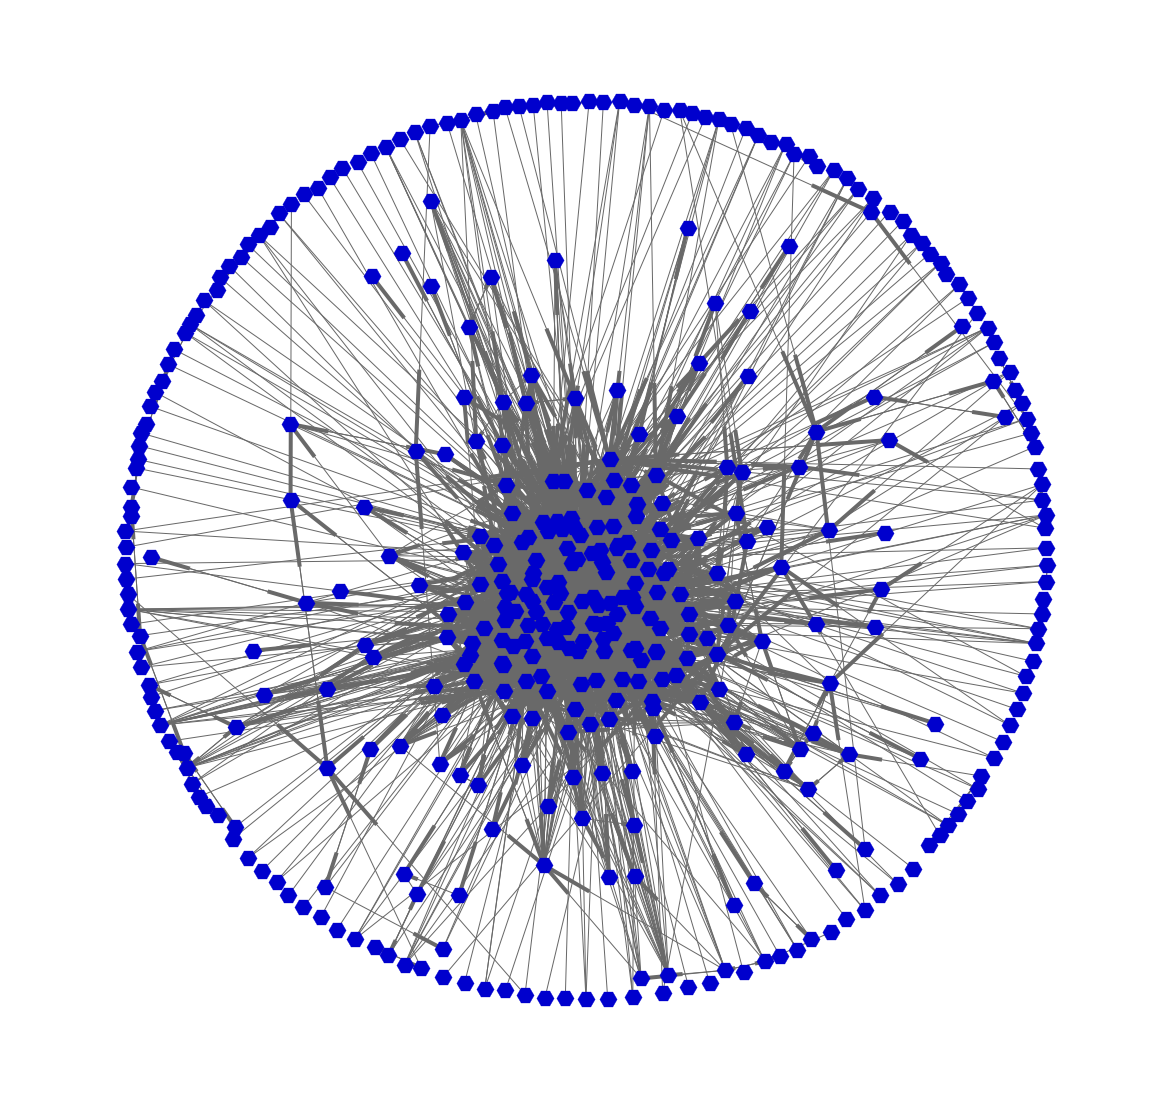

In [10]:
Global_graph = nx.DiGraph()


plt.figure(figsize=(20, 20))

Global_graph.add_nodes_from(list(nodesGCC))
Global_graph.add_edges_from(edgelistGCC)

pos=nx.spring_layout(Global_graph) # positions for all nodes 

nx.draw_networkx_nodes(Global_graph,pos,
                       list(nodesGCC),node_size=300,node_shape="H",node_color="mediumblue")
nx.draw_networkx_edges(Global_graph,pos,edge_color='dimgray')

plt.axis('off')

plt.savefig('Big_graph.png',bbox_inches='tight')
plt.show()

We can now compute some basic stats of the network (such as the number of nodes, edges, ...) :

In [11]:
dictdeg=Global_graph.degree(Global_graph.nodes())
degrees=list(dictdeg.values())
degrees=np.array(degrees)

dictindeg=Global_graph.in_degree(Global_graph.nodes())
degreesin=list(dictindeg.values())
degreesin=np.array(degreesin)

dictoutdeg=Global_graph.out_degree(Global_graph.nodes())
degreesout=list(dictoutdeg.values())
degreesout=np.array(degreesout)

print 'There are %s nodes in the Network\n' %(Global_graph.number_of_nodes())
print 'There are %s edges in the Network\n' %(Global_graph.number_of_edges())

print 'The average degree is %s for the Network\n' %(np.mean(degrees))
print 'The median degree is %s for the Network\n' %(np.median(degrees))

print 'The average in degree is %s for the Network\n' %(np.mean(degreesin))
print 'The median in degree is %s for the Network\n' %(np.median(degreesin))

print 'The average out degree is %s for the Network\n' %(np.mean(degreesout))
print 'The median out degree is %s for the Network\n' %(np.median(degreesout))

There are 415 nodes in the Network

There are 4673 edges in the Network

The average degree is 22.5204819277 for the Network

The median degree is 6.0 for the Network

The average in degree is 11.2602409639 for the Network

The median in degree is 2.0 for the Network

The average out degree is 11.2602409639 for the Network

The median out degree is 4.0 for the Network



We thus have 415 nodes and 4673 edges in the Network. We notice a big difference between the average and median degrees. The same for the in and out degrees. The explanation for this will come soon! Stay tuned!

We now show the top 10 characters according to there in and out degrees:

In [12]:
Char_by_key= collections.OrderedDict(sorted(dictdeg.items()))
Char_by_value_in= collections.OrderedDict(sorted(dictindeg.items(), key=lambda x: -x[1]))
Char_by_value_out= collections.OrderedDict(sorted(dictoutdeg.items(), key=lambda x: -x[1]))

print 'Out degrees: \n\n'

#we print the first 10 elements of the dictionary
for p,val in Char_by_value_out.items()[:10]:
    print '%s has an out degree of %s \n' %(p,val)


print '\n\nIn degrees: \n\n'
#we print the first 10 elements of the dictionary
for p,val in Char_by_value_in.items()[:10]:
    print '%s has an in degree of %s \n' %(p,val)


Out degrees: 


Albus Dumbledore has an out degree of 105 

Harry Potter has an out degree of 102 

Ronald Weasley has an out degree of 96 

Hermione Granger has an out degree of 87 

Tom Riddle has an out degree of 87 

Severus Snape has an out degree of 66 

Ginevra Weasley has an out degree of 66 

George Weasley has an out degree of 59 

Fred Weasley has an out degree of 59 

Minerva McGonagall has an out degree of 57 



In degrees: 


Harry Potter has an in degree of 264 

Tom Riddle has an in degree of 169 

Ronald Weasley has an in degree of 137 

Hermione Granger has an in degree of 128 

Albus Dumbledore has an in degree of 126 

Severus Snape has an in degree of 103 

Draco Malfoy has an in degree of 97 

Sirius Black has an in degree of 92 

Neville Longbottom has an in degree of 83 

Ginevra Weasley has an in degree of 81 



All the names that appear in these lists are famous Harry Potter characters. Something that we notice is that the members of the Weasley family tend to be higher ranked with the out degrees compared to the in degrees.

Now we can plot the in and out degree distribution. Let’s start with the out degree distribution:

The maximum out degree of the graph is 105 
The minimum out degree of the graph is 0 


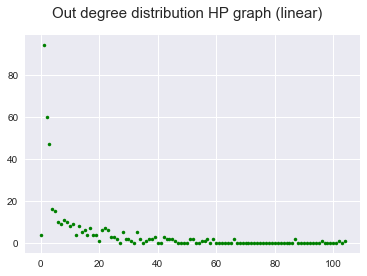

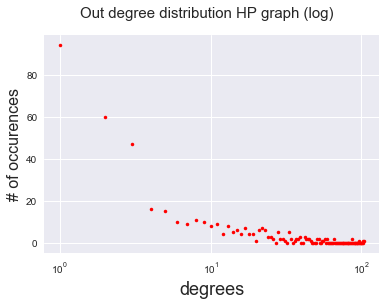

In [13]:
s=degreesout

maximum=np.max(s)
minimum=np.min(s)

print("The maximum out degree of the graph is %s " %maximum)
print("The minimum out degree of the graph is %s " %minimum)

bins=np.arange(minimum,maximum+1)

hist=np.histogram(s,bins)

fig1 = plt.figure()
fig1.suptitle('Out degree distribution HP graph (linear)', fontsize=15)

plt.xscale('linear')
plt.yscale('linear')
plt.plot(hist[1][:-1],hist[0],'g.')
plt.show()

fig = plt.figure()
plt.xscale('log')
plt.yscale('linear')
plt.plot(hist[1][:-1],hist[0],'r.')
fig.suptitle('Out degree distribution HP graph (log)', fontsize=15)
plt.xlabel('degrees', fontsize=18)
plt.ylabel('# of occurences', fontsize=16)
fig.savefig('HP_outgraph.png',bbox_inches='tight')
plt.show()

This is clearly a power law distribution! There are a lot of nodes with a low out degree and a few nodes with a high out degree. This explains the difference between median and average degree ;)

Let’s continue with the in degree distribution:

The maximum in degree of the graph is 264 
The minimum in degree of the graph is 0 


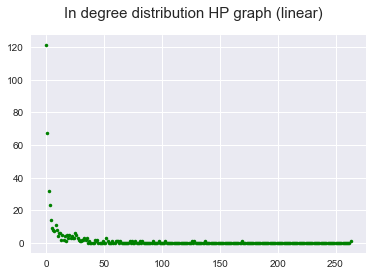

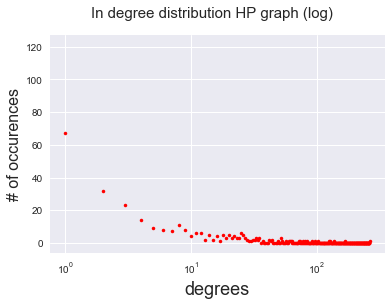

In [14]:
s=degreesin

maximum=np.max(s)
minimum=np.min(s)

print("The maximum in degree of the graph is %s " %maximum)
print("The minimum in degree of the graph is %s " %minimum)

bins=np.arange(minimum,maximum+1)

hist=np.histogram(s,bins)

fig1 = plt.figure()
fig1.suptitle('In degree distribution HP graph (linear)', fontsize=15)
plt.xscale('linear')
plt.yscale('linear')
plt.plot(hist[1][:-1],hist[0],'g.')
plt.show()

fig = plt.figure()
plt.xscale('log')
plt.yscale('linear')
plt.plot(hist[1][:-1],hist[0],'r.')
fig.suptitle('In degree distribution HP graph (log)', fontsize=15)
plt.xlabel('degrees', fontsize=18)
plt.ylabel('# of occurences', fontsize=16)
fig.savefig('HP_ingraph.png',bbox_inches='tight')
plt.show()

This is also clearly a power law distribution. There are a lot of nodes with a low in degree and a few nodes with a high in degree.

# Community analysis

We now want to capture the different communities in Harry Potter. We will analyse two different sets of communities: the houses in Harry Potter ( Gryffindor, Slytherin, Ravenclaw and Hufflepuff) and the Good and Bad Guys. There is in Harry Potter one community of bad guys: the Death Eaters. But also, several communities of good guys such as the Order of the Phoenix and the Army of Dumbledore.  We will count as good guys the members of the following categories: First Order of the Phoenix, Dumbledore’s Army and the Order of the Phoenix allies.

We had a little issue with Lord Voldemort. He is technically speaking not a death eater. Death Eaters are followers of Lord Voldemort. But we add him to the Death Eaters because after all he is the leader!


In [15]:
#2 dictionaries to capture the different communities :

#House of the character
Dict_House={}
#Death Eaters if he is a bad guy and Good Guys if he is a member of 
#['First Order of the Phoenix',"Dumbledore's Army",'Order of the Phoenix allies']
Dict_DE_VS_Good_Guys={}

for oldname in nodesGCC:
        #creating attributes
        ID=dict_of_char[oldname]
        for c in ['Gryffindors','Slytherins','Hufflepuffs','Ravenclaws']:
            if ID in Dict_cat_members[c].values():
                Dict_House[oldname]=c
        
        for c in ['Death Eaters']:#,'Death Eater allies']:
            if ID in Dict_cat_members[c].values():
                Dict_DE_VS_Good_Guys[oldname]='Death Eaters'
                
        for c in ['First Order of the Phoenix',"Dumbledore's Army",'Order of the Phoenix allies']:
            if ID in Dict_cat_members[c].values():
                Dict_DE_VS_Good_Guys[oldname]='Good Guys'
        

# We add Lord Voldemort to the Death Eaters because after all he is the leader!                
Dict_DE_VS_Good_Guys['Tom Riddle']='Death Eaters' 

print 'Done'

Done


We will use the **Louvain algorithm** to analyse the underlying communities in the harry potter network and visualise the results a **confusion matrix**. 

The Louvain algorithm is a greedy algorithm. We initialize each node in a separate community. There are as many communities as there are nodes.
Consists of a loop, that at each iteration performs two steps:
First we change community memberships to maximize modularity. So we evaluate for each node if the modularity is higher if he stays in his community or if he changes to the community of one of his neighbours.
Then we relabel the community of each node according to the previous step.
We stop when we have converged.

The confusion matrix is a matrix to compare two different sets of partitioning the data in non-overlapping communities. Element i,j of the matrix is the number of characters that are in both community i and community j. We will use the confusion matrix to compare the communities that are naturally present in Harry Potter (houses, Good and Bad Guys) versus the communities found by the Louvain algorithm.

Now we define a function that will apply the Louvain algorithm and after that will create and plot the confusion matrix. 

In [16]:
#This function will compute the optimal partition according to the louvain algorithm 
#and then compare it to the orignal communities in Harry Potter with a cnfusion matrix.

#arguments of the function are:
#G: the graph that we analyse
#listcat: the different natural categories that esxists (e.g. houses or good and bad Guys)
#dictcat: a dictinary mapping the characters (nodes of G) to the categories in listcat
#name: a name for saving the figure of the confusion matrix

#function returns:
#the modularity of the original communities
#the modularity of the louvain parttion
#the confussion Matrix
#the partition of the louvain algorithm
def Compute_modularity_and_plot_confussion_Matrix(G,listcat,dictcat,name):
    G_undir= G.to_undirected()
    number_internal_links={}
    total_degree={}
    L=G_undir.number_of_edges()
    
    #first compute the best partition
    partition = community.best_partition(G_undir)
    Mopt=community.modularity(partition, G_undir)
    print 'The modularity with the python Louvain algorithm on its optimal best partition %s \n' %Mopt
    
    #creating a dcitionary in order to use the community.modularity function
    Mdict={}
    commnbr=0
    for cat in listcat:
        commnbr+=1
        one_cat_list=[k for k,v in dictcat.items() if v==cat]
        for j in one_cat_list:
            Mdict[j]=commnbr
    
    #Now compute the modularity of the original communities
    M=community.modularity(Mdict, G_undir)
    print 'The modularity number of the groups using the Louvain algorithm modularity %s \n' %M
    
    #compute the number of partitions
    partition = community.best_partition(G_undir)
    number_of_partitions=max(partition.values())+1
    print 'There are %s partitions in the best partition solution' %number_of_partitions
    
    #sorting the communities from small to big
    importance_of_partition=collections.Counter(partition.values())
    importance_of_partition=collections.OrderedDict(sorted(importance_of_partition.items(), key=lambda x: -x[1]))
    
    trans={}
    for new_part_number,old_part_number in enumerate(importance_of_partition.keys()):
        trans[old_part_number]=new_part_number
    
    #new partition
    new_part={}
    #confussion matrix
    D=np.zeros((len(listcat),number_of_partitions))
    
    for i,cat in enumerate(listcat):

        house_list=[k for k,v in dictcat.items() if v==cat]
        for p in house_list:            
            j=trans[partition[p]]
            new_part[p]=j+1
            D[i,j]+=1
    
    #plotting confussion matrix
    plot_part=min(10,number_of_partitions)
    df_cm = pd.DataFrame(D[:,0:plot_part], index = [i for i in listcat],
                  columns = [i for i in range(1,plot_part+1)])
    plt.figure(figsize = (20,10))
    sn.set(font_scale=3)    
    g=sn.heatmap(df_cm, annot=True, annot_kws={"size": 30},linewidth=10)
    plt.savefig('Confusion_matrix_'+name+'.png',bbox_inches='tight')
    plt.show()
    sn.reset_orig()
    
    return M,Mopt,D,new_part

## The 4 houses: Gryffindor, Slytherin, Ravenclaw and Hufflepuff

Below you can see the Graph of all the characters that belong to on of the 4 houses in Harry Potter. The characters hat did not belong to any house were just neglected. 

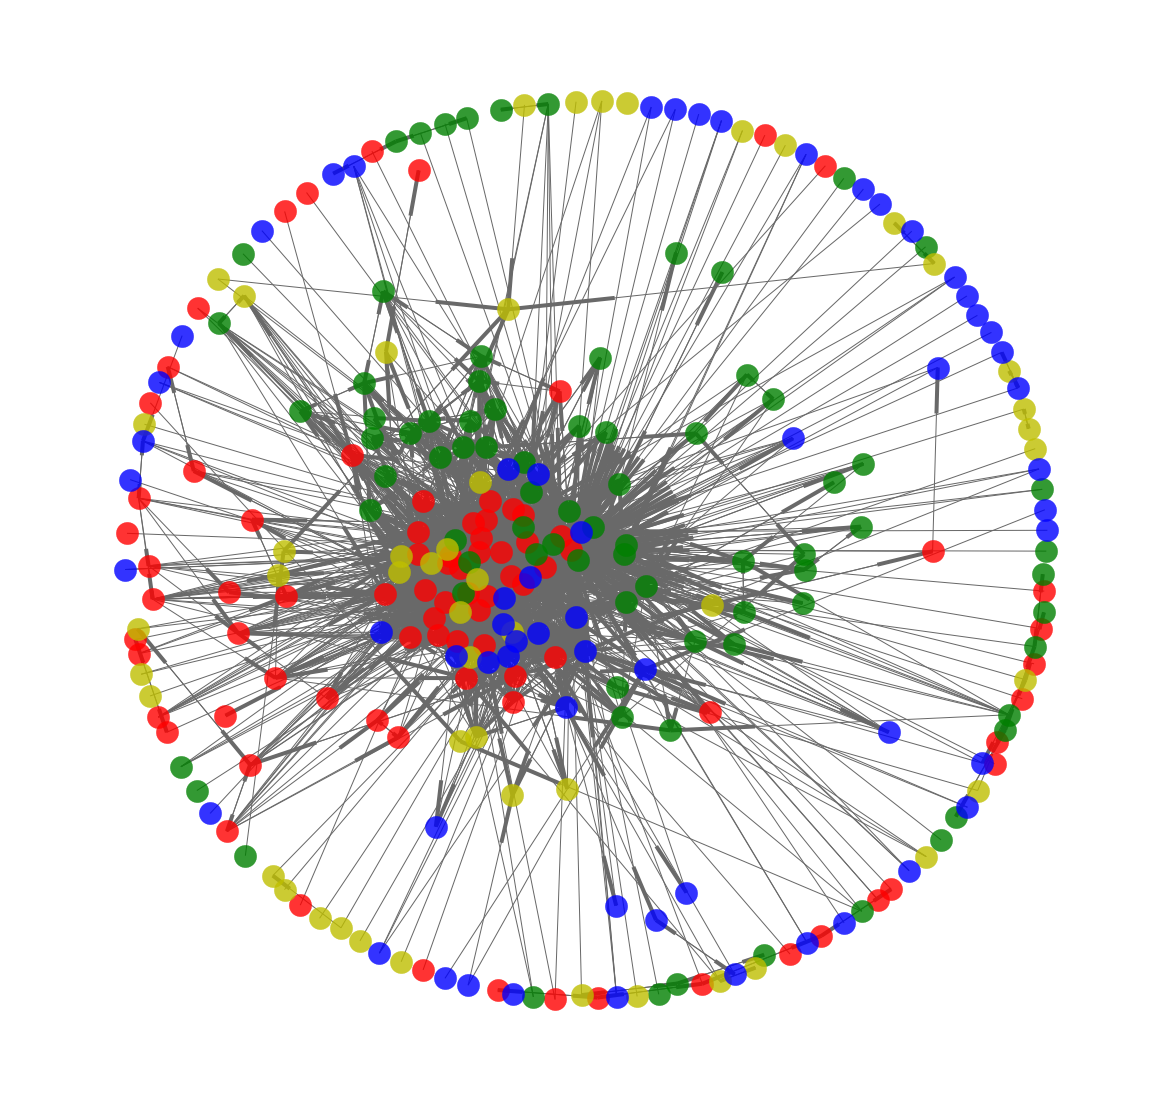

In [17]:
#graph of the houses
Ghouse = nx.DiGraph()
plt.figure(figsize=(20, 20))


Ghouse.add_nodes_from(Dict_House.keys())
Ghouse.add_edges_from([(a,b) for (a,b) in edgelist if a in Dict_House.keys() and b in Dict_House.keys()])


Gryffindor_nodes=[k for k,v in Dict_House.items() if v=='Gryffindors']
Slytherin_nodes=[k for k,v in Dict_House.items() if v=='Slytherins']
Hufflepuff_nodes=[k for k,v in Dict_House.items() if v=='Hufflepuffs']
Ravenclaw_nodes=[k for k,v in Dict_House.items() if v=='Ravenclaws']

pos=nx.spring_layout(Ghouse) # positions for all nodes 
#nx.set_node_attributes(G, 'House', Dict_House)
nx.draw_networkx_nodes(Ghouse,pos,
                       nodelist=Gryffindor_nodes,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(Ghouse,pos,
                       nodelist=Slytherin_nodes,
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(Ghouse,pos,
                       nodelist=Hufflepuff_nodes,
                       node_color='y',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(Ghouse,pos,
                       nodelist=Ravenclaw_nodes,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(Ghouse,pos,edge_color='dimgray')

plt.axis('off')

plt.savefig('Graph_house.png',bbox_inches='tight')
plt.show()

Here is a plot of network with only the House members. Red nodes are Gryffindor nodes. Green nodes are Slytherin nodes. Yellow nodes are Hufflepuff nodes. Blue nodes are Ravenclaw nodes.

We notice in the center a higher density of Gryffindor nodes. This makes sense since in Harry Potter, the main house (the house of Harry Potter) is Gryffindor.

Now we run the function *Compute_modularity_and_plot_confussion_Matrix* defined earlier on the House communities:

The modularity with the python Louvain algorithm on its optimal best partition 0.238359252595 

The modularity number of the groups using the Louvain algorithm modularity 0.106312747405 

There are 10 partitions in the best partition solution


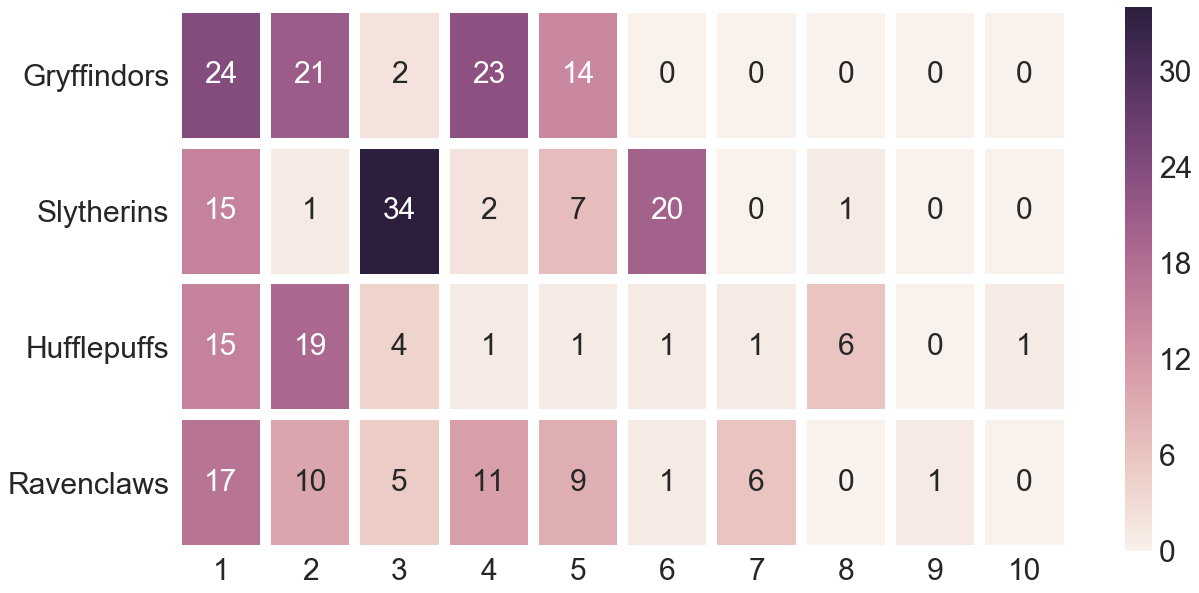

In [18]:
Mhouse,Mopthouse,Dhouse,partitionhouse=Compute_modularity_and_plot_confussion_Matrix(Ghouse,['Gryffindors','Slytherins','Hufflepuffs','Ravenclaws'],Dict_House,'Houses')

We notice that the modularity of the Louvain algorithm on its optimal partition is about 2 times better than the modularity of our 4 houses. This actually not too bad for an empirical solution, but remains far from the optimal.

In [ ]:
#print [k for k,v in partitionhouse.items() if v==2]

The different partitions are discussed on the website.

## Death eaters versus good guys

The next community we shall analyse is the Good versus Bad guys community. You can see the graph below. Again we have neglected nodes from which we did not have any information on the community membership.

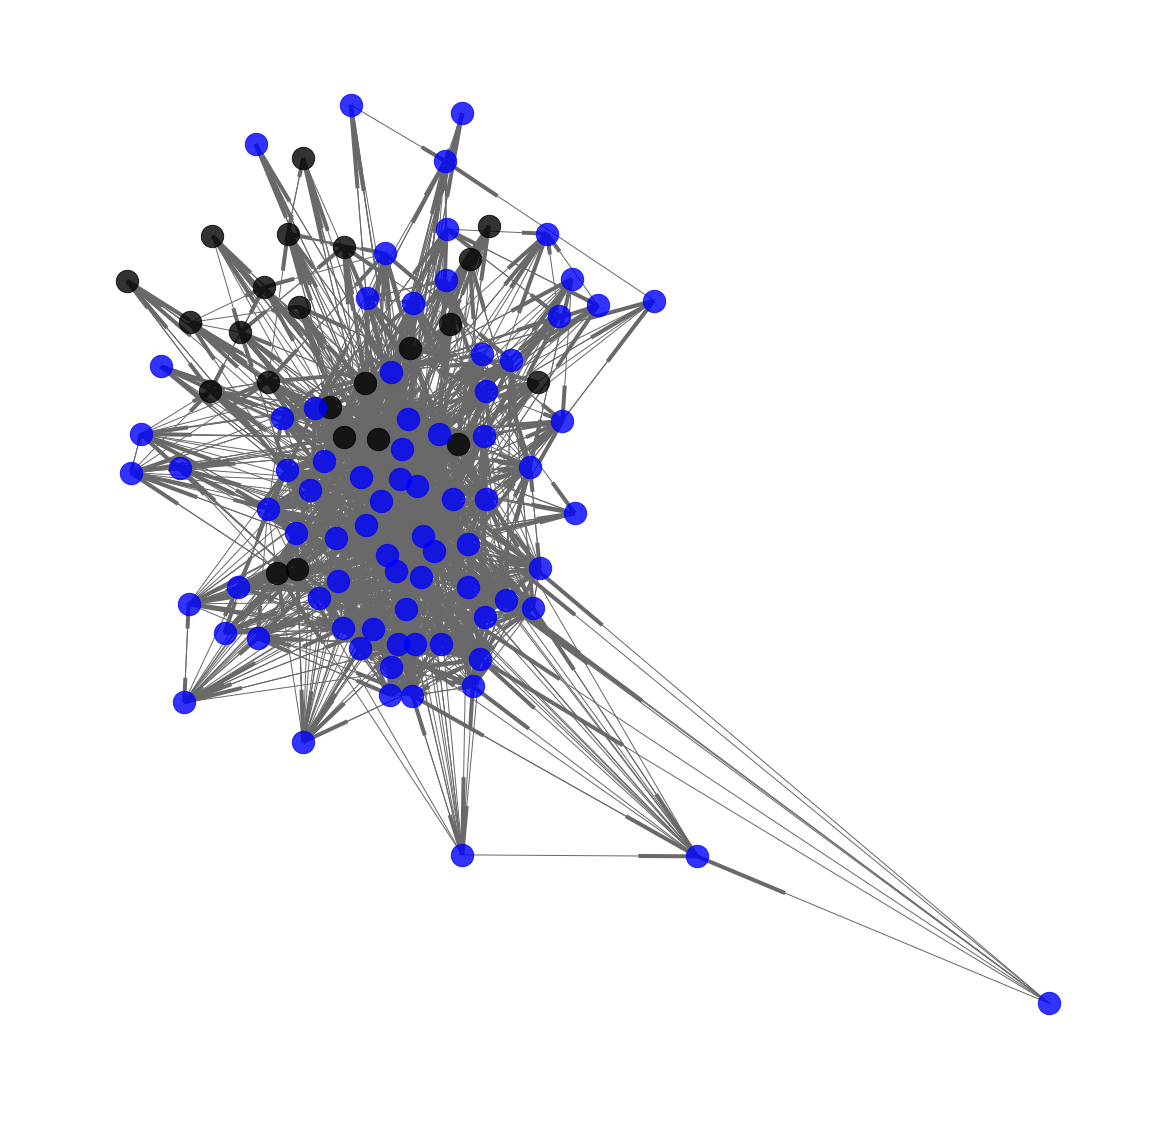

In [20]:
#graph of the good and bad guys
GDE = nx.DiGraph()
plt.figure(figsize=(20, 20))

GDE.add_nodes_from(Dict_DE_VS_Good_Guys.keys())
GDE.add_edges_from([(a,b) for (a,b) in edgelist if a in GDE.nodes() and b in GDE.nodes()])

DE_nodes=[k for k,v in Dict_DE_VS_Good_Guys.items() if v=='Death Eaters']
Good_Guys_nodes=[k for k,v in Dict_DE_VS_Good_Guys.items() if v=='Good Guys']


pos=nx.spring_layout(GDE) # positions for all nodes 
#nx.set_node_attributes(G, 'House', Dict_House)
nx.draw_networkx_nodes(GDE,pos,
                       nodelist=DE_nodes,
                       node_color='k',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(GDE,pos,
                       nodelist=Good_Guys_nodes,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)


nx.draw_networkx_edges(GDE,pos,edge_color='dimgray')

plt.axis('off')

plt.savefig('Graph_DE_good_guys.png',bbox_inches='tight')
plt.show()

The Death Eater community is in black, while the Good guys are in blue. There are way less bad guys than good guys. We also notice that Networkx tend to plot the Death Eaters together. This is already nice to see!

The modularity with the python Louvain algorithm on its optimal best partition 0.185227134045 

The modularity number of the groups using the Louvain algorithm modularity 0.0472041719532 

There are 4 partitions in the best partition solution


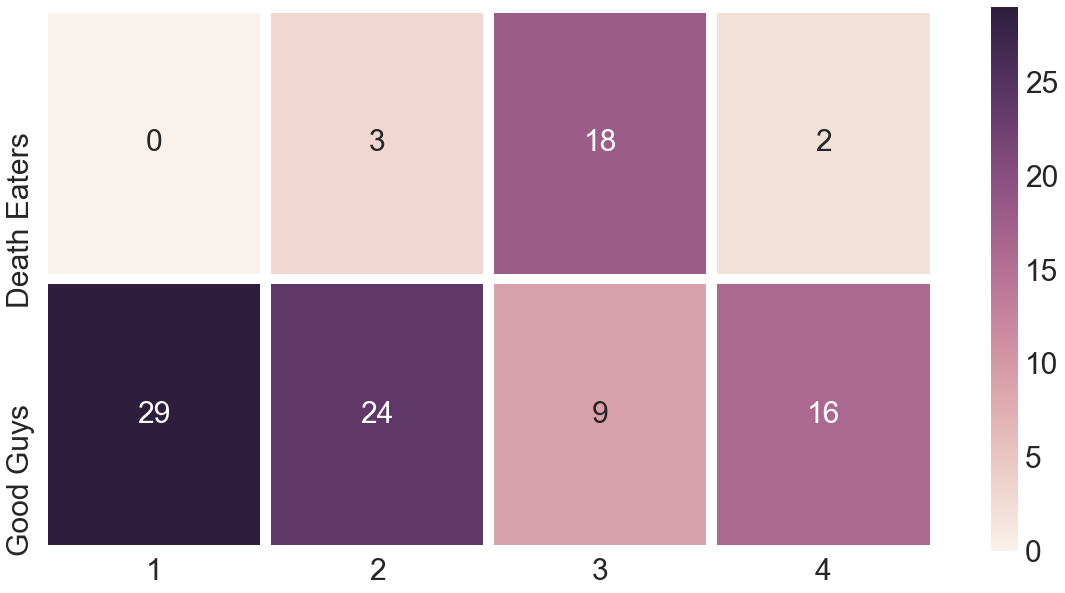

In [21]:
M,Mopt,D,partitionGDE=Compute_modularity_and_plot_confussion_Matrix(GDE,['Death Eaters','Good Guys'],Dict_DE_VS_Good_Guys,'Good_bad_guys')

We notice that the modularity of the Louvain algorithm on its optimal partition is about 4 times better than the modularity of our basic groups. This must be because we decided to divide the characters only in two clusters while the Louvain algorithm chose 4. He thus does smaller clusters, this increases the modularity.

### discussion of the partitions

In [22]:
print [k for k,v in partitionGDE.items() if v==1]


[u'Cho Chang', u'Anthony Goldstein', u'Susan Bones', u'Colin Creevey', u'Angelina Johnson', u'Lavender Brown', u'Romilda Vane', u'Seamus Finnigan', u'Terry Boot', u'Luna Lovegood', u'George Weasley', u'Michael Corner', u'Padma Patil', u'Leanne', u'Fred Weasley', u'Neville Longbottom', u'Dean Thomas', u'Hannah Abbott', u'Nigel Wolpert', u'Cormac McLaggen', u'Oliver Wood', u'Lee Jordan', u'Bem', u'Alicia Spinnet', u'Justin Finch-Fletchley', u'Ernest Macmillan', u'Katie Bell', u'Parvati Patil', u'Ginevra Weasley']


In [23]:
print [k for k,v in partitionGDE.items() if v==2]

[u'Alastor Moody', u'Winky', u'Selwyn', u'Percy Weasley', u'Benjy Fenwick', u'Elphias Doge', u'Albus Dumbledore', u'Emmeline Vance', u'Xenophilius Lovegood', u'Aberforth Dumbledore', u'Augustus Rookwood', u'Harry Potter', u'Dedalus Diggle', u'Fawkes', u'Ronald Weasley', u'Caradoc Dearborn', u'Muriel', u'Dorcas Meadowes', u'Sturgis Podmore', u'Kreacher', u'Travers', u'Mundungus Fletcher', u'Marlene McKinnon', u'Peeves', u'Garrick Ollivander', u'Dobby', u'Edgar Bones']


In [24]:
print [k for k,v in partitionGDE.items() if v==3]

[u'Rosier', u'Rodolphus Lestrange', u'Lestrange', u'Rabastan Lestrange', u'Wilkes', u'Thorfinn Rowle', u'Jugson', u'Severus Snape', u'Edward Tonks', 'Tom Riddle', u'Goyle', u'Crabbe', u'Bellatrix Lestrange', u'Antonin Dolohov', u'Walden Macnair', u'Evan Rosier', u'Sirius Black', u'Andromeda Tonks', u'Dark Mark', u'Gideon Prewett', u'Nott', u'Gibbon', u'Bartemius Crouch Junior', u'Fabian Prewett', u'Frank Longbottom', u'Augusta Longbottom', u'Alice Longbottom']


In [25]:
print [k for k,v in partitionGDE.items() if v==4]

[u'James Potter I', u'Alecto Carrow', u'Horace Slughorn', u'Pomona Sprout', u'Nicholas de Mimsy-Porpington', u'Poppy Pomfrey', u'Peter Pettigrew', u'Hermione Granger', u'Firenze', u'Dennis Creevey', u'Filius Flitwick', u'Amycus Carrow', u'Remus Lupin', u'Grawp', u'Rubeus Hagrid', u'Lily J. Potter', u'Sybill Trelawney', u'Buckbeak']


After having discussed the partition we can also make a plot in Networkx. We have kept the same colors as the previous plot: the Death Eater community is in black, while the Good guys are in blue.
But we added shapes! Each number corresponds to the community found by the Louvain algorithm.


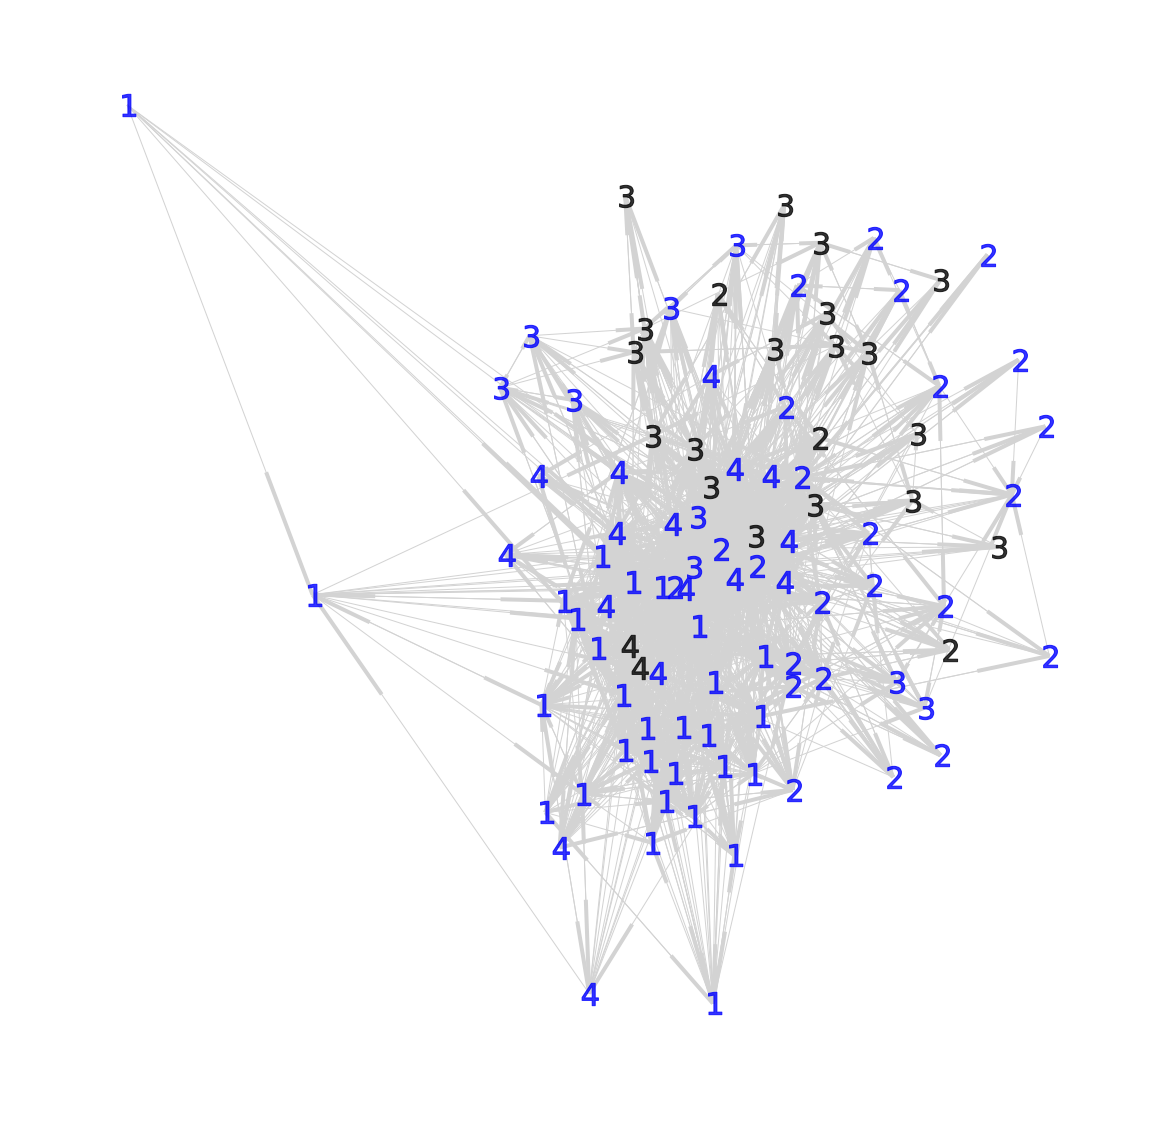

In [26]:
#graph of the good and bad guys
GDE = nx.DiGraph()
plt.figure(figsize=(20, 20))



GDE.add_nodes_from(Dict_DE_VS_Good_Guys.keys())
GDE.add_edges_from([(a,b) for (a,b) in edgelist if a in GDE.nodes() and b in GDE.nodes()])


DE_nodes=[k for k,v in Dict_DE_VS_Good_Guys.items() if v=='Death Eaters']
Good_Guys_nodes=[k for k,v in Dict_DE_VS_Good_Guys.items() if v=='Good Guys']

labels={}
for char in GDE.nodes():

        labels[char]=r''+char

pos=nx.spring_layout(GDE) # positions for all nodes 

x,y=D.shape
shapes=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']

for val in range(1,y+1):
    current_shape=shapes[val]
    current_partition=[k for k,v in partitionGDE.items() if v==val]
    nx.draw_networkx_nodes(GDE,pos,
                           nodelist=[n for n in current_partition if n in DE_nodes],
                           node_color='k',
                           node_shape=current_shape,
                           node_size=500,
                       alpha=0.8)
    nx.draw_networkx_nodes(GDE,pos,
                           nodelist=[n for n in current_partition if n in Good_Guys_nodes],
                           node_color='b',
                           node_shape=current_shape,
                           node_size=500,
                       alpha=0.8)

#nx.draw_networkx_labels(G,pos,labels,font_size=20,font_color='saddlebrown')



nx.draw_networkx_edges(GDE,pos,edge_color='lightgrey')

plt.axis('off')

plt.savefig('Graph_DE_good_guys.png',bbox_inches='tight')
plt.show()

# Betweeness and other stats of the Network

In this section we are trying to find out which characters are the most central. These are the most important characters. For this we used different tools such as betweenness centrality, PageRank, eigenvector centrality and the HITS algorithm.

**Betweenness centrality** of a node is the sum of the fraction of all-pairs shortest paths that pass through that node. A node that has a lot of shortest paths going through him must be important. Betweenness centrality is applied on an undirected graph. While PageRank and Eigenvector centrality are both applied on directed graphs.

In [27]:
numberprint=10

UG=Global_graph.to_undirected()
bet_cent=nx.betweenness_centrality(UG)
bet_cent_by_value= collections.OrderedDict(sorted(bet_cent.items(), key=lambda x: -x[1]))

print 'Betweenness centrality :\n\n' 
#we print the first 5 elements of the dictionary
for p,cent in bet_cent_by_value.items()[:numberprint]:
    print '%s has a betweenness centrality of %s \n' %(p,cent)


betweenness centrality :


Harry Potter has a betweenness centrality of 0.445850266101 

Tom Riddle has a betweenness centrality of 0.110326386775 

Albus Dumbledore has a betweenness centrality of 0.0680780421212 

Ronald Weasley has a betweenness centrality of 0.0647167618249 

Hermione Granger has a betweenness centrality of 0.0374770431547 

Cedric Diggory has a betweenness centrality of 0.0328549689684 

Dudley Dursley has a betweenness centrality of 0.0299469811028 

Pomona Sprout has a betweenness centrality of 0.0266431220893 

Nicholas de Mimsy-Porpington has a betweenness centrality of 0.0256168931441 

Horace Slughorn has a betweenness centrality of 0.0255580751685 



This algorithm is what made Google famous. It was the first algorithm the founders of Google developed for the search engine.  **PageRank** attempts to measure a node’s importance. This theory supposes that the most important nodes in the network are the nodes with the most links leading to them. 
PageRank thinks of links as votes, where a node linking to another node is casting a vote. If an important node votes for you, this means you are important. You can also interprete the PageRank of a node as following : the probability of starting at a random node of ending up on this node just by following links of other nodes chosen randomly. 



In [28]:
deg_assort=nx.degree_assortativity_coefficient(G)   
print '\nPageRank :\n\n' 
cent_page=nx.pagerank(Global_graph)
cent_page= collections.OrderedDict(sorted(cent_page.items(), key=lambda x: -x[1]))

for p,cent in cent_page.items()[:numberprint]:
    print '%s has a PageRank of %s \n' %(p,cent)


PageRank :


Harry Potter has a PageRank of 0.0512711057635 

Tom Riddle has a PageRank of 0.0323680536023 

Albus Dumbledore has a PageRank of 0.0229809331594 

Ronald Weasley has a PageRank of 0.0217938269599 

Hermione Granger has a PageRank of 0.0212445814008 

Severus Snape has a PageRank of 0.0170553954349 

Draco Malfoy has a PageRank of 0.0165278395843 

Sirius Black has a PageRank of 0.0152553448068 

Rubeus Hagrid has a PageRank of 0.0139307869648 

Ginevra Weasley has a PageRank of 0.0133231492762 



The principle behind the computation of **eigenvector centrality** is about the same as PageRank. Actually PageRank is based on eigenvector computations. But where we can think of the PageRank of a node as the probability to land on this node just by following this link we cannot do the same with an eigenvector centrality.

In [29]:
eig_cent_in=nx.eigenvector_centrality(Global_graph)
eig_cent_by_value_in= collections.OrderedDict(sorted(eig_cent_in.items(), key=lambda x: -x[1]))
print '\nEigenvector centrality in edges :\n\n' 
#we print the first 5 elements of the dictionary
for p,cent  in eig_cent_by_value_in.items()[:numberprint]:
    print '%s has a eigenvector centrality in edges of %s \n' %(p,cent)


eig_cent_out=nx.eigenvector_centrality(Global_graph.reverse())
eig_cent_by_value_out= collections.OrderedDict(sorted(eig_cent_out.items(), key=lambda x: -x[1]))
print '\nEigenvector centrality out edges :\n\n' 
#we print the first 5 elements of the dictionary
for p,cent in eig_cent_by_value_out.items()[:numberprint]:
    print '%s has a eigenvector centrality out edges of %s \n' %(p,cent)


eigenvector centrality in edges :


Harry Potter has a eigenvector centrality in edges of 0.24765695023 

Tom Riddle has a eigenvector centrality in edges of 0.240152350121 

Hermione Granger has a eigenvector centrality in edges of 0.212635827562 

Ronald Weasley has a eigenvector centrality in edges of 0.210300779798 

Albus Dumbledore has a eigenvector centrality in edges of 0.206410068362 

Severus Snape has a eigenvector centrality in edges of 0.18527389836 

Draco Malfoy has a eigenvector centrality in edges of 0.184362009698 

Sirius Black has a eigenvector centrality in edges of 0.179124086463 

Ginevra Weasley has a eigenvector centrality in edges of 0.170808221398 

Neville Longbottom has a eigenvector centrality in edges of 0.166494820293 


eigenvector centrality out edges :


Ronald Weasley has a eigenvector centrality out edges of 0.204660299554 

Harry Potter has a eigenvector centrality out edges of 0.204238318157 

Albus Dumbledore has a eigenvector centrality out edg

This is the last tool we will use to distinguish important nodes in the graph. **HITS** stands for Hyperlink-Induced Topic Search. This algorithm was also used in the early search engines. It returns 2 type of nodes: Hubs and Authorities. The idea is that some nodes are important because everybody links to them (plenty of people know them): Authorities. While some nodes are valuable because they link to plenty of other nodes (they help people that do not know a lot of other node): Hubs. A node is a good hub if it links to good authorities and a node is a good authority if it is linked to by good hubs.

In [30]:
hubs,authorities=nx.hits(G)
hubs= collections.OrderedDict(sorted(hubs.items(), key=lambda x: -x[1]))
authorities= collections.OrderedDict(sorted(authorities.items(), key=lambda x: -x[1]))

print '\nHubs :\n\n' 

for p,cent in hubs.items()[:numberprint]:
    print '%s has a hub score of %s \n' %(p,cent)

print '\nAuthorities :\n\n'    
    
for p,cent in authorities.items()[:numberprint]:
    print '%s has a authority score of %s \n' %(p,cent)


Hubs :


Ronald Weasley has a hub score of 0.0145468725929 

Harry Potter has a hub score of 0.0143182311914 

Albus Dumbledore has a hub score of 0.0141896422589 

Hermione Granger has a hub score of 0.0134320307898 

Ginevra Weasley has a hub score of 0.0115786424164 

George Weasley has a hub score of 0.0114068348101 

Fred Weasley has a hub score of 0.0113590602156 

Tom Riddle has a hub score of 0.0113474640627 

Severus Snape has a hub score of 0.0108179923531 

Minerva McGonagall has a hub score of 0.0105565899362 


Authorities :


Harry Potter has a authority score of 0.030226099546 

Tom Riddle has a authority score of 0.0265405032449 

Ronald Weasley has a authority score of 0.0241126933452 

Hermione Granger has a authority score of 0.0237208782658 

Albus Dumbledore has a authority score of 0.0224101160942 

Severus Snape has a authority score of 0.0205128152155 

Draco Malfoy has a authority score of 0.0193041054965 

Sirius Black has a authority score of 0.0186588114354

The next cell is not interesting. We just change the structure of the data. The only thing that is more relevant is that we normalize each centrality measure with respect to its maximum to be able to plot it in the next cell.

In [75]:
set_of_plot_char=set()
dict_char2nbr={}
dict_plot={'Authorities':[],'Hubs':[],'PageRank':[],
           'Eigenvector cent out':[],'Eigenvector cent in':[],'Betweenness centrality':[]
          }
n=0

for p,cent in cent_page.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['PageRank'].append((dict_char2nbr[p],cent/cent_page.values()[0])) 

for p,cent in authorities.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['Authorities'].append((dict_char2nbr[p],cent/authorities.values()[0]))  
dict_char2nbr= collections.OrderedDict(sorted(dict_char2nbr.items(), key=lambda x: x[1]))    

for p,cent in hubs.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['Hubs'].append((dict_char2nbr[p],cent/hubs.values()[0]))

for p,cent in eig_cent_by_value_out.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['Eigenvector cent out'].append((dict_char2nbr[p],cent/eig_cent_by_value_out.values()[0]))   
    
for p,cent in bet_cent_by_value.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['Betweenness centrality'].append((dict_char2nbr[p],cent/bet_cent_by_value.values()[0]))
    
for p,cent  in eig_cent_by_value_in.items()[:numberprint]:
    if p not in set_of_plot_char:
        dict_char2nbr[p]=n
        n+=1
        set_of_plot_char.add(p)
    dict_plot['Eigenvector cent in'].append((dict_char2nbr[p],cent/eig_cent_by_value_in.values()[0]))    
 

Here is the promised plot of the different centrality measures. The different centrality measures were normalized so the maximum is at 100% and the following are percentages of this maximum.

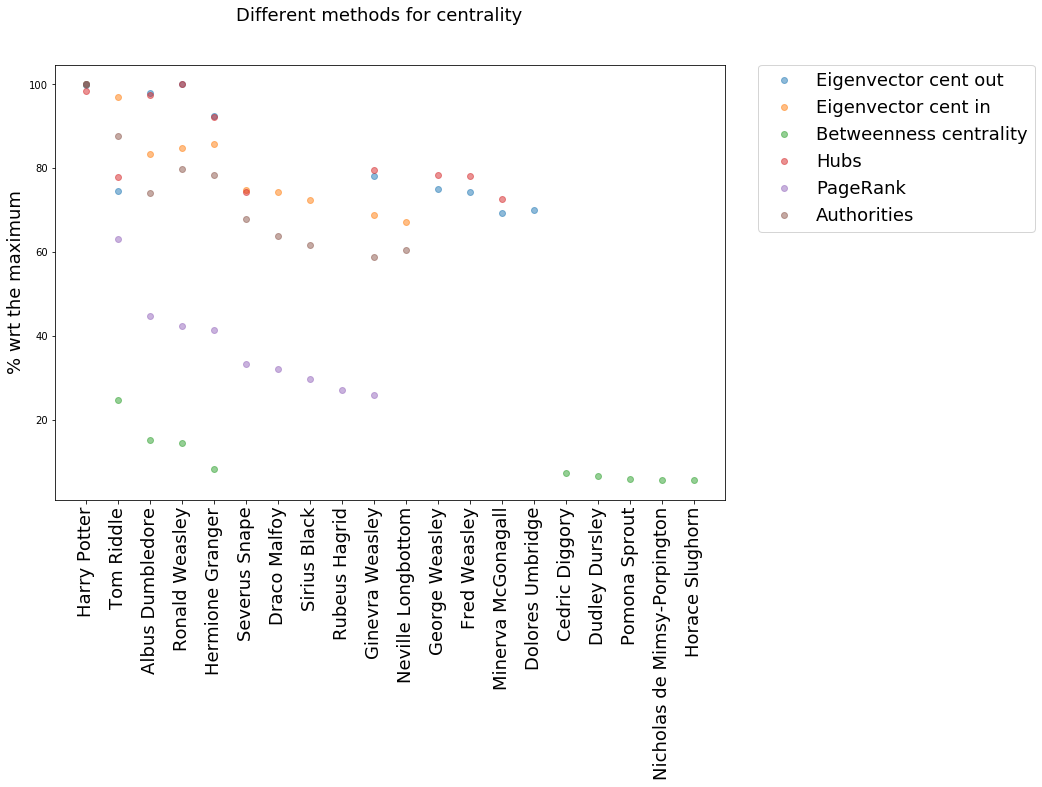

In [76]:
fig, ax = plt.subplots(1,1)
# plt.xscale('log')
# plt.yscale('linear')
fig.set_size_inches(12,8)
fig.suptitle('Different methods for centrality', fontsize=18)

plt.ylabel('% wrt the maximum', fontsize=18)



for method,methodtuplelist in dict_plot.items():
    x=[i for i,j in methodtuplelist]
    y=[100*j for i,j in methodtuplelist]
    plt.plot(x,y,'o', label=method,alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=18)
my_xticks = dict_char2nbr.keys()
ax.set_xticks(range(len(dict_char2nbr.keys())))
ax.set_xticklabels(my_xticks,rotation='vertical', fontsize=18)
fig.savefig('HP_central_methods.png',bbox_inches='tight')
plt.show()

discussion can be found on the website